In [1]:
from math import log
import random
import numpy as np
import cvxpy as cp
from math import sqrt

In [2]:
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

plt.rcParams['font.size'] = 14.0
plt.rcParams['axes.labelsize'] = 22
plt.rcParams['axes.titlesize'] = 22
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['legend.fontsize'] = 18
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams.update({'mathtext.default': 'regular' })

In [3]:
def create_sparse_vector(n, s):
    x = np.zeros(n)  # Initialize zero vector
    indices = np.random.permutation(n)[:s]  # Randomly select s indices
    x[indices] = np.random.randn(s)  # Assign random values at selected indices

    return x

In [4]:
def loss_fn(A, b, x):
    return cp.sum_squares(A @ x - b)

def lasso_regularizer(x):
    return cp.norm1(x)

def ridge_regularizer(x):
    return cp.sum_squares(x)

def lasso_objective_fn(A, b, x, lambd):
    return loss_fn(A, b, x) + lambd * lasso_regularizer(x)

def ridge_objective_fn(A, b, x, lambd):
    return loss_fn(A, b, x) + lambd * ridge_regularizer(x)

## Question 1.

$A \in \mathbb{R}^{m \times n}$ and $x_s \in \mathbb{R}^n$ with $s$ number of nonzero elements. Let $m \gtrapprox 2s \log (n) \ll n$

In [5]:
np.random.seed(44)
random.seed(44)

<>:46: SyntaxWarning: invalid escape sequence '\l'
<>:46: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipykernel_1852432/1157332175.py:46: SyntaxWarning: invalid escape sequence '\l'
  plt.xlabel('$\lambda$')


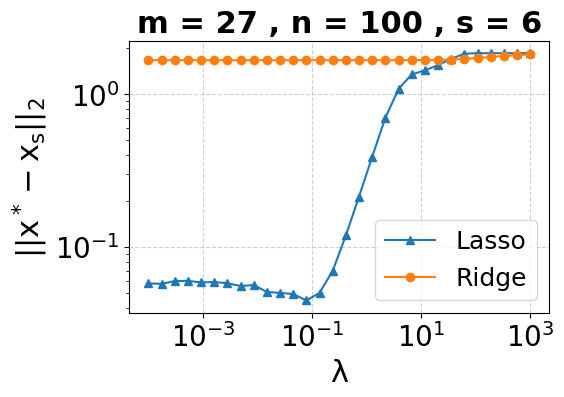

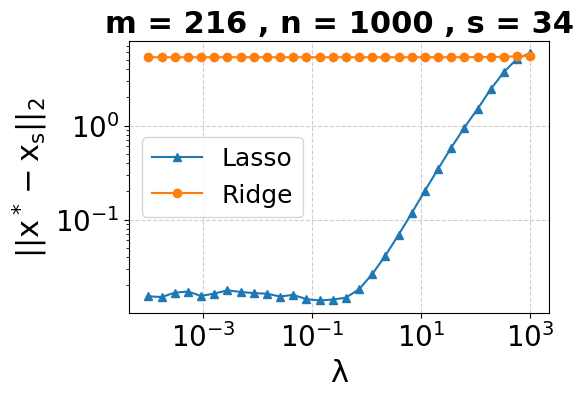

In [6]:
for m, n, s in [(27, 100, 6), (216, 1000, 34)]: # (216, 1000, 34)

    # Create Problem
    A = np.random.randn(m, n)
    x_s = create_sparse_vector(n, s)
    e = 0.01 * np.random.randn(m)
    b = A @ x_s + e


    # Solve with cvx
    x_lasso = cp.Variable(n)
    x_ridge = cp.Variable(n)

    lambd = cp.Parameter(nonneg=True)

    lasso_prob = cp.Problem(cp.Minimize(lasso_objective_fn(A, b, x_lasso, lambd)))
    ridge_prob = cp.Problem(cp.Minimize(ridge_objective_fn(A, b, x_ridge, lambd)))

    lambd_values = np.logspace(-4, 3, 30)

    lasso_err = []
    ridge_err = []

    for v in lambd_values:
        lambd.value = v

        lasso_prob.solve()
        ridge_prob.solve()

        lasso_err.append(np.linalg.norm(x_lasso.value - x_s, 2))
        ridge_err.append(np.linalg.norm(x_ridge.value - x_s, 2))



    pdf = PdfPages(f'plots/xerror_{m}_{n}.pdf')

    plt.figure(figsize=(6, 4))

    plt.plot(lambd_values, lasso_err, label="Lasso", marker='^')
    plt.plot(lambd_values, ridge_err, label="Ridge", marker='o')

    # Add grid
    plt.grid(True, linestyle='--', alpha=0.6)

    # Label the axes
    plt.xlabel('$\lambda$')
    plt.ylabel('$||x^* - x_s||_2$')

    plt.legend()

    plt.xscale('log')
    plt.yscale('log')

    plt.subplots_adjust(bottom=0.2, left=0.2)

    plt.title(f"m = {m} , n = {n} , s = {s}")

    pdf.savefig(plt.gcf()) # Save the current figure
    plt.show()
    plt.close()
    pdf.close()

## Question 2.

In [7]:
def sgn(x):
    return np.where(x < 0, -1, 1)

In [8]:
def lasso_grad(A, x, b, lambd):
    return A.T @ (A @ x - b) + lambd * sgn(x)

def lasso_f(A, x, b, lambd):
    tmp = A @ x - b
    return 0.5 * np.dot(tmp, tmp) + lambd * np.linalg.norm(x, 1)

In [22]:
def lasso_subgradient_descent(A, x, b, lambd, f_opt, c):
    
    k = 0
    f = lasso_f(A, x, b, lambd)
    
    differences = []
    
    while f >= c * f_opt:
        
        grad = lasso_grad(A, x, b, lambd)
        
        x = x - (1 / (sqrt(k + 1) * np.linalg.norm(grad, 2))) * grad
            
        k += 1
        
        f = lasso_f(A, x, b, lambd)
        
        differences.append(f - f_opt)
                 
    return x, differences

In [56]:
np.random.seed(44)
random.seed(44)

<>:43: SyntaxWarning: invalid escape sequence '\l'
<>:43: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipykernel_1852432/3047238553.py:43: SyntaxWarning: invalid escape sequence '\l'
  plt.plot(k, differences, label=f"$\lambda$ = {l}")


f_opt: 0.044146821690723904, f: 0.04856114493945473
f_opt: 0.439174973568684, f: 0.4830710856326794
f_opt: 4.216731683833691, f: 4.638130625674717
f_opt: 28.3739001750712, f: 31.008262808839973


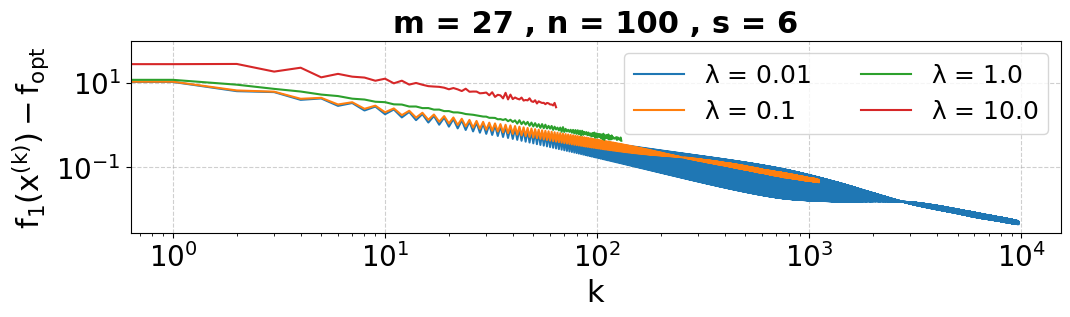

f_opt: 0.286950581520335, f: 0.31564323155147755
f_opt: 2.868643088097689, f: 3.1554653845117153
f_opt: 28.600252201865676, f: 31.45634592634835
f_opt: 279.6181821454764, f: 307.51560210629935


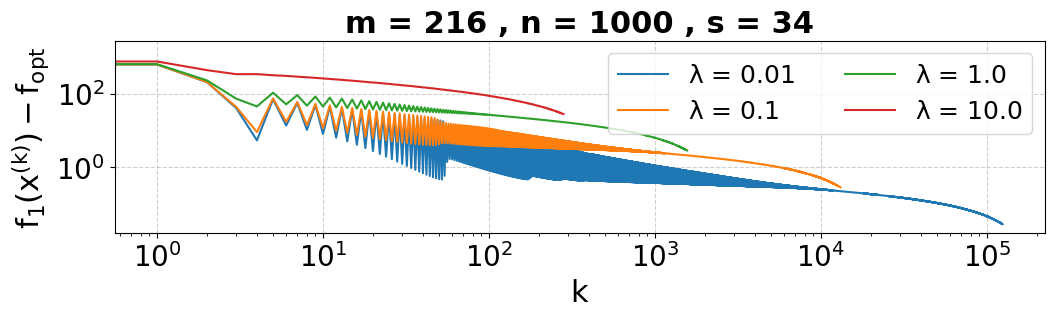

In [57]:
for m, n, s in [(27, 100, 6), (216, 1000, 34)]: # (216, 1000, 34)

    # Create Problem
    A = np.random.randn(m, n)
    x_s = create_sparse_vector(n, s)
    e = 0.01 * np.random.randn(m)
    b = A @ x_s + e


    # Solve with cvx
    x_lasso = cp.Variable(n)
    lambd = cp.Parameter(nonneg=True)
    lasso_prob = cp.Problem(cp.Minimize(lasso_objective_fn(A, b, x_lasso, lambd)))

    lambd_values = [0.01, 0.1, 1., 10.]
    
    results = []

    for l in lambd_values:
        lambd.value = l

        lasso_prob.solve()

        lasso_err.append(np.linalg.norm(x_lasso.value - x_s, 2))

        x = np.zeros(n)
        f_opt = lasso_f(A, x_lasso.value, b, l)
        
        x_subgrad, differences = lasso_subgradient_descent(A, x, b, l, f_opt, 1.1)
        
        print(f'f_opt: {f_opt}, f: {lasso_f(A, x_subgrad, b, l)}')
        
        results.append(differences)
        
    
    pdf = PdfPages(f'plots/diff_{m}_{n}.pdf')
    plt.figure(figsize=(12, 3))
    
    for l, differences in zip(lambd_values, results):
        
        k = [i for i in range(len(differences))]

        plt.plot(k, differences, label=f"$\lambda$ = {l}")

    # Add grid
    plt.grid(True, linestyle='--', alpha=0.6)

    # Label the axes
    plt.xlabel('$k$')
    plt.ylabel('$f_1(x^{(k)}) - f_{opt}$')

    plt.legend(ncols=2, loc='upper right')

    plt.xscale('log')
    plt.yscale('log')

    plt.subplots_adjust(bottom=0.24)

    plt.title(f"m = {m} , n = {n} , s = {s}")

    pdf.savefig(plt.gcf()) # Save the current figure
    plt.show()
    plt.close()
    pdf.close()
    
    